## Chapter 3: Random network

<p> In this code i created an ER graph, having roughly the same amount of nodes and edges than our subreddit graph and then I compared the two. </p>

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import gc
import time
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import poisson

In [2]:
def func(x,a,b):
    return a*(x)**(b)

In [13]:
#import and clean data
data = pd.read_csv("../scraping data/data/data_subreddit_cleaned.csv",index_col=0)
G = nx.convert_matrix.from_pandas_edgelist(data,source = "parent",target="to",
                                                        edge_attr=True,create_using=nx.DiGraph())

<p>After importing the data, the first problem i faced was to make sure to have an ER graph with the same amount of nodes and edges of the subreddit graph.<br> Startin from the formula: $<L> = p\frac{N(N-1)}{2}$, where $<L>$ is the avarage number of links, N the number of nodes in the graph and p the probability of forming an edge, i computed the probability p necessary to have an ER graph with $<L>$ equal to the number of links in the subreddits graph.</p>

In [14]:
#save number of nodes and number of edges
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
print("Number of nodes: {}, Number of edges: {}".format(n_nodes,n_edges))
#compute the probability k and create ER graph
prob = 2*n_edges/(n_nodes*(n_nodes-1))
print("Probability ER graph to have the same amount on nodes and edges: {:.3f}%".format(prob*100))

Number of nodes: 24819, Number of edges: 107094
Probability ER graph to have the same amount on nodes and edges: 0.035%


<p>After that I computed the degree distribution for the ER graph and the subreddit graph.<br>
    Using a bilogarithmic plot it is easy to see that the subreddit distribution follows a polinomial distribution in the form:
    $ax^{b}$<br>
Hence i used a simple optimization routine to find the best parameters a,b that best descirbe the subreddit degree distribution. </p>

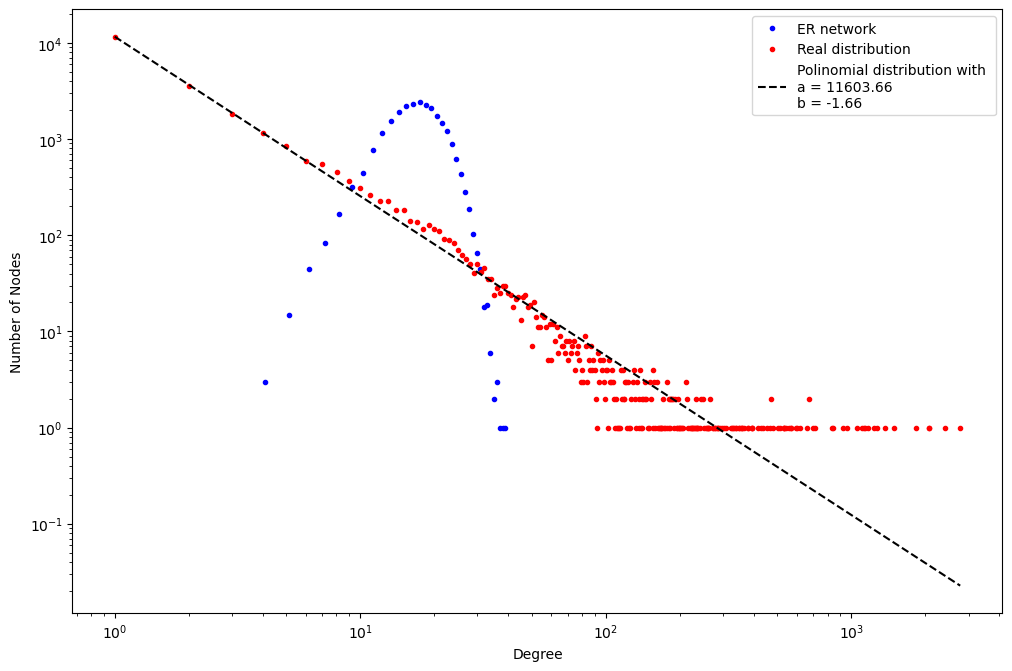

In [15]:
er = nx.fast_gnp_random_graph(n_nodes, prob,directed=True)
fig=plt.figure(figsize=(12,8), dpi= 100)
#compute probability distribution for ER and real graph
hist_er = np.array(nx.degree_histogram(er))
hist = np.array(nx.degree_histogram(G))
#plot degree distribution for ER and real graph
x = np.linspace(0,len(hist_er),len(hist_er))
plt.plot(x, hist_er, ".", label="ER network",color="blue")
xx = np.linspace(1,len(hist),len(hist)-1)
plt.plot(xx, hist[1:], ".",label = "Real distribution",color="red")
#compute best parameter to approximate real distribution
popt, pcov = curve_fit(func, xx, hist[1:],p0=(1e8,-2))
label="Polinomial distribution with \na = {:.2f}\nb = {:.2f}".format(popt[0],popt[1])
plt.plot(xx, func(xx, *popt), color ='black',label=label,ls="--")
# nice plot
plt.loglog()
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.legend()
plt.show()

<p> Lastly I carried out a basic graph analysis of the ER graph</p>

In [38]:
# clustering and density analysis
a_cluster = nx.average_clustering(er)
density = nx.density(er)
print("Avarage clustering coefficient: {:.5f} \nDensity: {:.5f}".format(a_cluster,density))

Avarage clustering coefficient: 0.00035 
Density: 0.00035


In [37]:
#connected component analysis
n_strong = nx.number_strongly_connected_components(er)
n_weak = nx.number_weakly_connected_components(er)
print(nx.is_strongly_connected(er),n_strong,n_weak)

False 9 1


In [18]:
#regime analysis
mean_k = (n_nodes-1)*prob
print("<k>={:.0f} \nln(N)= {:.0f} \nThis means we are in the supercritical regime".format(mean_k,np.log(n_nodes)))

<k>=9 
ln(N)= 10 
This means we are in the supercritical regime


In [55]:
# shortest path analysis
mean_short_lenght = nx.average_shortest_path_length(er)
print("average shortest path lenght {:.2f}".format(mean_short_lenght))

average shortest path lenght 4.93


lastly I computed the k_max and k_min of the ER graph 

In [22]:
deg=[]
for tup in nx.degree(er):
    deg.append(tup[1])
    
print("K_max of ER model {}" .format(max(deg)))
print("K_min of ER model {}" .format(min(deg)))

K_max of ER model 38
K_min of ER model 4


In [23]:
deg=[]
for tup in nx.degree(G):
    deg.append(tup[1])
    
print("K_max of real graph {}" .format(max(deg)))
print("K_min of real graph {}" .format(min(deg)))

K_max of real graph 2774
K_min of real graph 1


## Configuration model

In [45]:
#create a configuration model network from our original network
din = list(d for n, d in G.in_degree())
dout = list(d for n, d in G.out_degree())
cm = nx.directed_configuration_model(din, dout)
cm = nx.DiGraph(cm)

In [46]:
#connected component analysis
n_strong = nx.number_strongly_connected_components(cm)
n_weak = nx.number_weakly_connected_components(cm)
print(nx.is_strongly_connected(cm),n_strong,n_weak)

False 21251 8


In [50]:
# clustering and density analysis
a_cluster = nx.average_clustering(cm)
density = nx.density(cm)
print("Avarage clustering coefficient: {:.5f} \nDensity: {:.5f}".format(a_cluster,density))

Avarage clustering coefficient: 0.03446 
Density: 0.00017


In [59]:
# shortest path analysis biggest component
comps = list(nx.weakly_connected_components(cm))
mean_short_lenght = nx.average_shortest_path_length(cm.subgraph(comps[0]))
print("average shortest path lenght {:.2f}".format(mean_short_lenght))

average shortest path lenght 0.70


## Configuration vs Er

In [66]:
dict_res = {}
lst_index = ["weakly connected components","Avg clustering coeffincient","density","k_max","k_min","<k>","avg shortest path","distribution"]
lst_er  = [1,0.00035,0.00035,38,4,9,4.93,"poissonian"]
dict_res["Er Graph"] = lst_er
lst_cm = [8,0.03446,0.00017,2774,1,"same as real",0.70,"same as real"]
dict_res["Configuration Graph"] = lst_cm
pd.DataFrame(dict_res,index=lst_index)

,Er Graph,Configuration Graph
weakly connected components,1,8
Avg clustering coeffincient,0.00035,0.03446
density,0.00035,0.00017
k_max,38,2774
k_min,4,1
<k>,9,same as real
avg shortest path,4.93,0.7
distribution,poissonian,same as real
